#Libraries


In [ ]:

!pip install scikit-fuzzy nltk pandas matplotlib seaborn transformers torch
!pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from datetime import datetime, timedelta
from google.colab import files

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


np.random.seed(42)
torch.manual_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 16.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = ('/content/drive/My Drive/archive/Stress/Reddit_Combi.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df = pd.read_excel(file_path)
print("Dataset loaded successfully!")
print(f"Dataset size: {len(df)}")

print("\nDataset preview:")
print(df.head())
print("\nDataset columns:")
print(df.columns)
print("\nDataset info:")
print(df.info())


print("\nClass distribution:")
print(df['label'].value_counts())


print("\nMissing values:")
print(df.isnull().sum())


df['text'] = df['title'] + ' ' + df['body']
print("\nSample combined text:")
print(df['text'].head())

Dataset loaded successfully!
Dataset size: 3123

Dataset preview:
                                               title  \
0                     Envy to other is swallowing me   
1  Nothin outta the ordinary. Paradise. Job stres...   
2  Almost 49 and the chasm of emptiness has never...   
3                                    I’m happy again   
4  Is it possible to recover from such a traumati...   

                                                body  \
0  Im from developingcountry, Indonesia , and for...   
1  Um hello ....well many can relate im sure. Aft...   
2  I’ve been diagnosed severe bi polar where you ...   
3  After my closest friend left me in April, I ha...   
4  I am only 15, and yet I feel my life is alread...   

                                          Body_Title  label  
0  Envy to other is swallowing me Im from develop...      1  
1  Nothin outta the ordinary. Paradise. Job stres...      1  
2  Almost 49 and the chasm of emptiness has never...      1  
3  I’m happy

Text preprocessing completed!
                                                text  \
0  Envy to other is swallowing me Im from develop...   
1  Nothin outta the ordinary. Paradise. Job stres...   
2  Almost 49 and the chasm of emptiness has never...   
3  I’m happy again After my closest friend left m...   
4  Is it possible to recover from such a traumati...   

                                      processed_text  
0  envy swallowing im developingcountry indonesia...  
1  nothin outta ordinary paradise job stress life...  
2  almost chasm emptiness never greater ive diagn...  
3  im happy closest friend left april finally let...  
4  possible recover traumatic childhood yet feel ...  

Average text length: 544.35 characters
Minimum text length: 15 characters
Maximum text length: 16624 characters


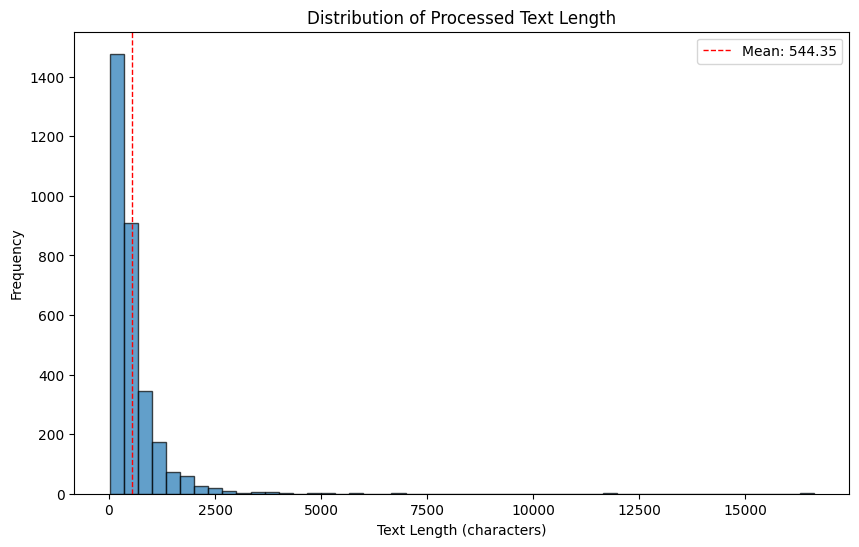

In [ ]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return ""


    text = str(text).lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)

    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(tokens)


df['body'] = df['body'].fillna('')

df['text'] = df['title'] + ' ' + df['body']


df['processed_text'] = df['text'].apply(preprocess_text)

print("Text preprocessing completed!")
print(df[['text', 'processed_text']].head())


df['text_length'] = df['processed_text'].apply(len)
print(f"\nAverage text length: {df['text_length'].mean():.2f} characters")
print(f"Minimum text length: {df['text_length'].min()} characters")
print(f"Maximum text length: {df['text_length'].max()} characters")


plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Processed Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.axvline(df['text_length'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df["text_length"].mean():.2f}')
plt.legend()
plt.show()

Training set size: 2498
Test set size: 625

Class distribution in training set:
label
1    2196
0     302
Name: count, dtype: int64

Class distribution in test set:
label
1    549
0     76
Name: count, dtype: int64


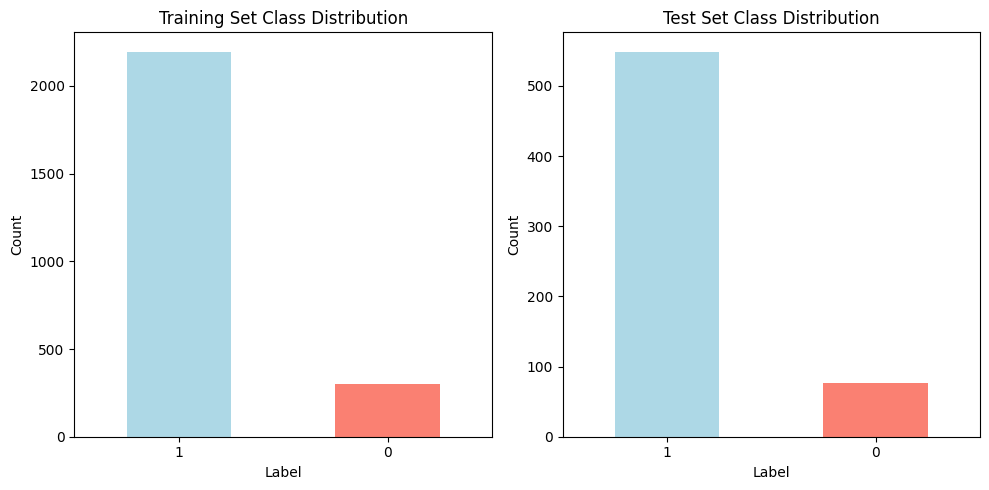

In [ ]:

X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in test set:")
print(y_test.value_counts())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Training Set Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Test Set Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [ ]:

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF features shape:", X_train_tfidf.shape)
print(f"Number of features: {X_train_tfidf.shape[1]}")

TF-IDF features shape: (2498, 5000)
Number of features: 5000


# Model 1

In [ ]:
#load saved model

import joblib
import pickle

loaded_classifier = joblib.load('stress_classifier.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
with open('fuzzy_stress_system.pkl', 'rb') as f:
    loaded_fuzzy_system = pickle.load(f)

print("All model components loaded successfully!")

All model components loaded successfully!


Accuracy: 0.8912

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58        76
           1       0.95      0.93      0.94       549

    accuracy                           0.89       625
   macro avg       0.75      0.77      0.76       625
weighted avg       0.90      0.89      0.89       625



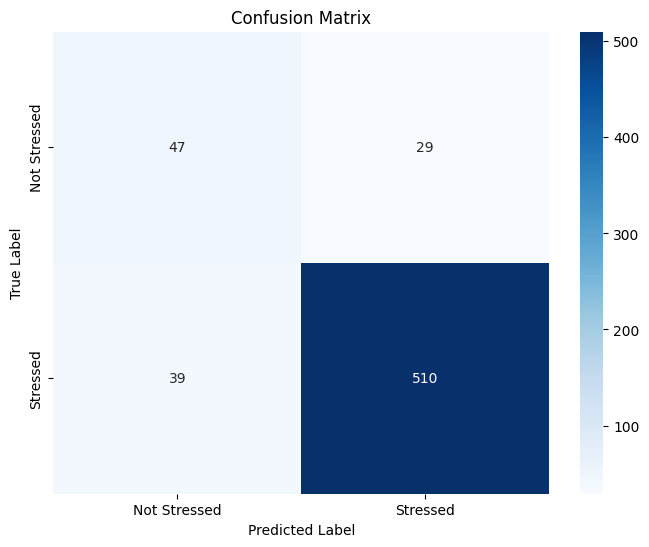

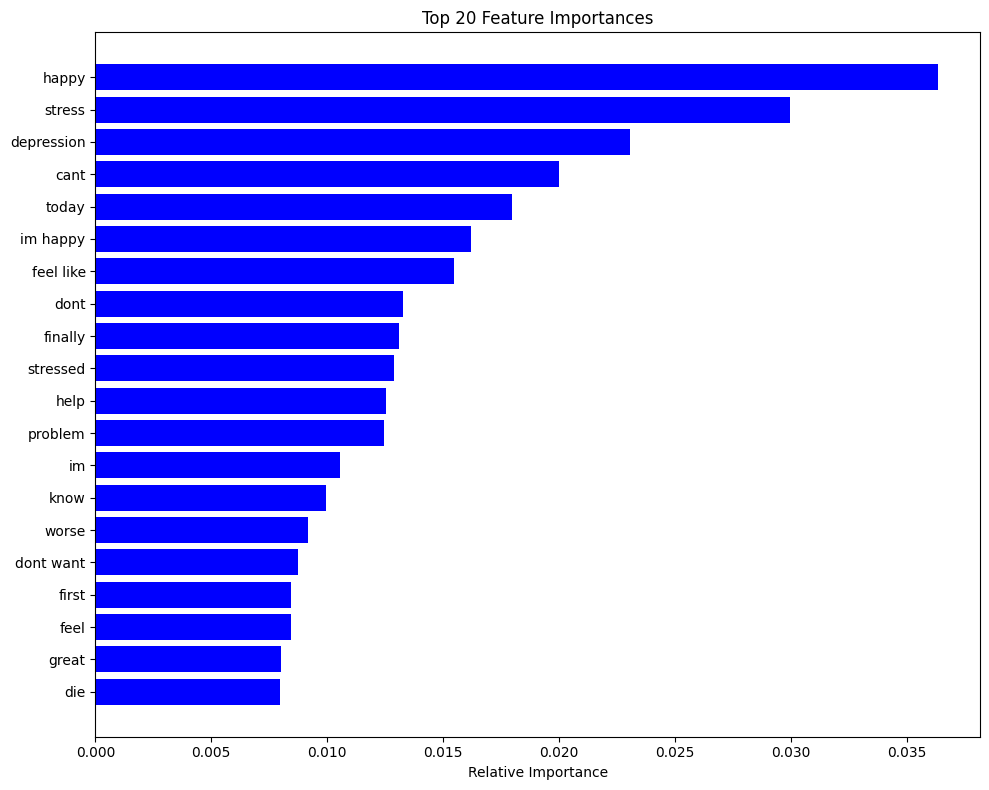

In [ ]:

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5
)
rf_classifier.fit(X_train_tfidf, y_train)

y_pred = rf_classifier.predict(X_test_tfidf)
y_pred_proba = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Stressed', 'Stressed'],
            yticklabels=['Not Stressed', 'Stressed'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


feature_names = tfidf_vectorizer.get_feature_names_out()
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

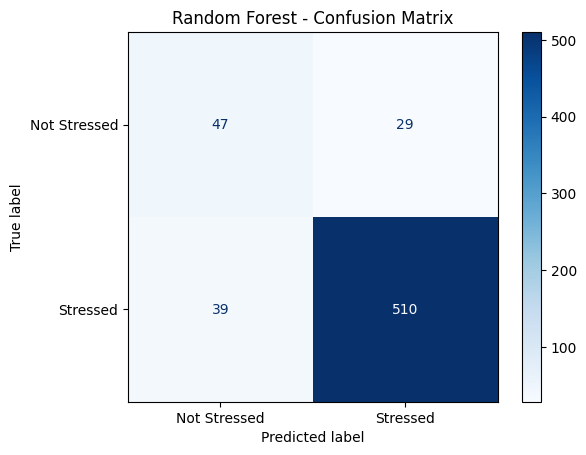

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Stressed', 'Stressed'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Random Forest - Confusion Matrix')
plt.show()

In [ ]:

stress_level = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'stress_level')
message_frequency = ctrl.Antecedent(np.arange(0, 11, 1), 'message_frequency')
time_between_messages = ctrl.Antecedent(np.arange(0, 61, 1), 'time_between_messages')  # in minutes
overall_stress_score = ctrl.Consequent(np.arange(0, 101, 1), 'overall_stress_score')


stress_level['low'] = fuzz.trimf(stress_level.universe, [0, 0, 0.4])
stress_level['medium'] = fuzz.trimf(stress_level.universe, [0.3, 0.5, 0.7])
stress_level['high'] = fuzz.trimf(stress_level.universe, [0.6, 1, 1])


message_frequency['low'] = fuzz.trimf(message_frequency.universe, [0, 0, 3])
message_frequency['medium'] = fuzz.trimf(message_frequency.universe, [2, 5, 8])
message_frequency['high'] = fuzz.trimf(message_frequency.universe, [7, 10, 10])


time_between_messages['short'] = fuzz.trimf(time_between_messages.universe, [0, 0, 15])
time_between_messages['medium'] = fuzz.trimf(time_between_messages.universe, [10, 30, 50])
time_between_messages['long'] = fuzz.trimf(time_between_messages.universe, [45, 60, 60])


overall_stress_score['low'] = fuzz.trimf(overall_stress_score.universe, [0, 0, 40])
overall_stress_score['medium'] = fuzz.trimf(overall_stress_score.universe, [30, 50, 70])
overall_stress_score['high'] = fuzz.trimf(overall_stress_score.universe, [60, 100, 100])


rules = [
    ctrl.Rule(stress_level['low'] & message_frequency['low'] & time_between_messages['long'], overall_stress_score['low']),
    ctrl.Rule(stress_level['low'] & message_frequency['low'] & time_between_messages['medium'], overall_stress_score['low']),
    ctrl.Rule(stress_level['low'] & message_frequency['low'] & time_between_messages['short'], overall_stress_score['low']),
    ctrl.Rule(stress_level['low'] & message_frequency['medium'] & time_between_messages['long'], overall_stress_score['low']),
    ctrl.Rule(stress_level['low'] & message_frequency['medium'] & time_between_messages['medium'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['low'] & message_frequency['medium'] & time_between_messages['short'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['low'] & message_frequency['high'] & time_between_messages['long'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['low'] & message_frequency['high'] & time_between_messages['medium'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['low'] & message_frequency['high'] & time_between_messages['short'], overall_stress_score['high']),
    ctrl.Rule(stress_level['medium'] & message_frequency['low'] & time_between_messages['long'], overall_stress_score['low']),
    ctrl.Rule(stress_level['medium'] & message_frequency['low'] & time_between_messages['medium'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['medium'] & message_frequency['low'] & time_between_messages['short'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['medium'] & message_frequency['medium'] & time_between_messages['long'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['medium'] & message_frequency['medium'] & time_between_messages['medium'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['medium'] & message_frequency['medium'] & time_between_messages['short'], overall_stress_score['high']),
    ctrl.Rule(stress_level['medium'] & message_frequency['high'] & time_between_messages['long'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['medium'] & message_frequency['high'] & time_between_messages['medium'], overall_stress_score['high']),
    ctrl.Rule(stress_level['medium'] & message_frequency['high'] & time_between_messages['short'], overall_stress_score['high']),
    ctrl.Rule(stress_level['high'] & message_frequency['low'] & time_between_messages['long'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['high'] & message_frequency['low'] & time_between_messages['medium'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['high'] & message_frequency['low'] & time_between_messages['short'], overall_stress_score['high']),
    ctrl.Rule(stress_level['high'] & message_frequency['medium'] & time_between_messages['long'], overall_stress_score['medium']),
    ctrl.Rule(stress_level['high'] & message_frequency['medium'] & time_between_messages['medium'], overall_stress_score['high']),
    ctrl.Rule(stress_level['high'] & message_frequency['medium'] & time_between_messages['short'], overall_stress_score['high']),
    ctrl.Rule(stress_level['high'] & message_frequency['high'] & time_between_messages['long'], overall_stress_score['high']),
    ctrl.Rule(stress_level['high'] & message_frequency['high'] & time_between_messages['medium'], overall_stress_score['high']),
    ctrl.Rule(stress_level['high'] & message_frequency['high'] & time_between_messages['short'], overall_stress_score['high'])
]


stress_ctrl = ctrl.ControlSystem(rules)
stress_detector = ctrl.ControlSystemSimulation(stress_ctrl)

def calculate_stress_score(stress_prob, msg_freq, avg_time_gap):
    stress_detector.input['stress_level'] = stress_prob
    stress_detector.input['message_frequency'] = msg_freq
    stress_detector.input['time_between_messages'] = avg_time_gap

    try:
        stress_detector.compute()
        return stress_detector.output['overall_stress_score']
    except:
        return stress_prob * 100

#Simulation group chat

Simulating College Group Chat...
Group Chat Stress Analysis
Total messages: 15
Active users: 5
User Alice:
  Messages: 3
  Avg Stress Probability: 0.475
  Avg Time Between Messages: 1.5 minutes
  Final Stress Score: 86.49

User Bob:
  Messages: 3
  Avg Stress Probability: 0.475
  Avg Time Between Messages: 12.5 minutes
  Final Stress Score: 68.08

User Charlie:
  Messages: 3
  Avg Stress Probability: 0.475
  Avg Time Between Messages: 15.0 minutes
  Final Stress Score: 50.00

User Diana:
  Messages: 4
  Avg Stress Probability: 0.476
  Avg Time Between Messages: 1.0 minutes
  Final Stress Score: 86.50

User Ethan:
  Messages: 2
  Avg Stress Probability: 0.452
  Avg Time Between Messages: 15.0 minutes
  Final Stress Score: 82.38

Overall Group Stress Score: 74.69
Stress Level: High - The group appears to be significantly stressed


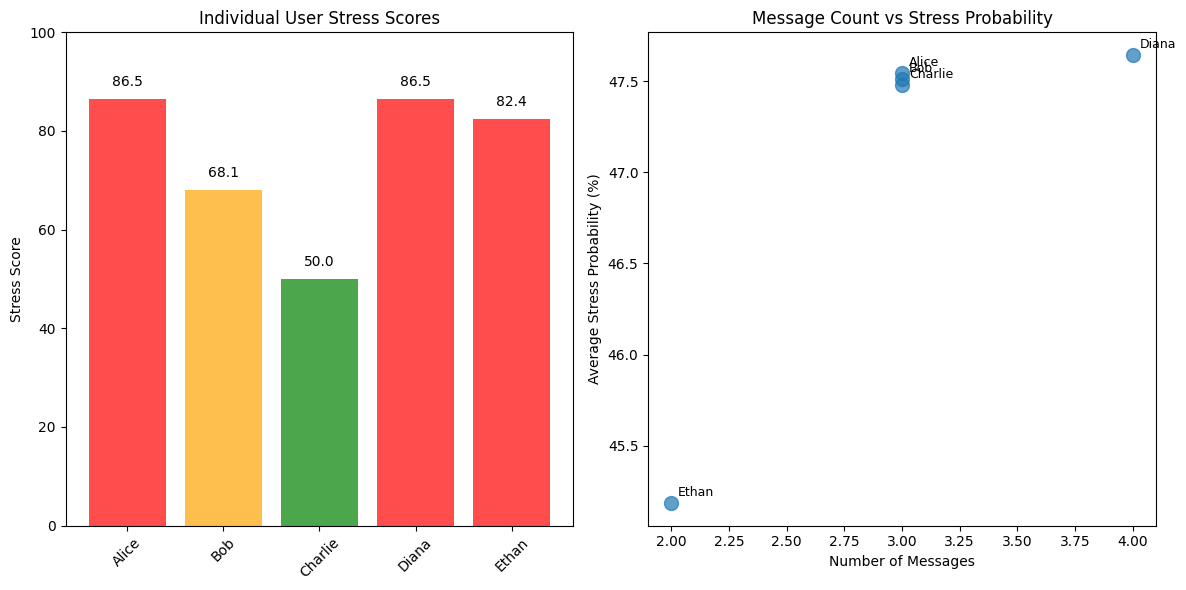


Detailed Statistics:
Alice:
  Messages: 3
  Avg Stress Probability: 0.475
  Avg Time Gap: 1.5 minutes
  Final Score: 86.49

Bob:
  Messages: 3
  Avg Stress Probability: 0.475
  Avg Time Gap: 12.5 minutes
  Final Score: 68.08

Charlie:
  Messages: 3
  Avg Stress Probability: 0.475
  Avg Time Gap: 15.0 minutes
  Final Score: 50.00

Diana:
  Messages: 4
  Avg Stress Probability: 0.476
  Avg Time Gap: 1.0 minutes
  Final Score: 86.50

Ethan:
  Messages: 2
  Avg Stress Probability: 0.452
  Avg Time Gap: 15.0 minutes
  Final Score: 82.38

Group Average: 74.69


In [ ]:
# Simulate a group chat with multiple users and messages
class GroupChatSimulator:
    def __init__(self, classifier, vectorizer):
        self.classifier = classifier
        self.vectorizer = vectorizer
        self.users = {}
        self.messages = []

    def add_message(self, user_id, text, timestamp=None):
        if timestamp is None:
            timestamp = datetime.now()

        # Preprocess text
        processed_text = preprocess_text(text)

        # Extract features
        features = self.vectorizer.transform([processed_text])

        # Predict stress probability
        stress_prob = self.classifier.predict_proba(features)[0][1]

        # Store message
        message_data = {
            'user_id': user_id,
            'text': text,
            'processed_text': processed_text,
            'stress_prob': stress_prob,
            'timestamp': timestamp
        }
        self.messages.append(message_data)

        # Update user stats
        if user_id not in self.users:
            self.users[user_id] = {
                'message_count': 0,
                'total_stress': 0,
                'last_message_time': None,
                'time_gaps': [],
                'messages': []
            }

        user = self.users[user_id]
        user['message_count'] += 1
        user['total_stress'] += stress_prob
        user['messages'].append(message_data)

        # Calculate time gap if this isn't the first message from this user
        if user['last_message_time'] is not None:
            time_gap = (timestamp - user['last_message_time']).total_seconds() / 60  # in minutes
            user['time_gaps'].append(time_gap)

        user['last_message_time'] = timestamp

        return stress_prob

    def get_user_stress_score(self, user_id):
        if user_id not in self.users:
            return 0

        user = self.users[user_id]

        if user['message_count'] == 0:
            return 0

        # Calculate average stress probability
        avg_stress_prob = user['total_stress'] / user['message_count']

        # Calculate message frequency (messages per hour)
        if len(user['messages']) > 1:
            first_msg_time = user['messages'][0]['timestamp']
            last_msg_time = user['messages'][-1]['timestamp']
            time_span_hours = (last_msg_time - first_msg_time).total_seconds() / 3600

            if time_span_hours > 0:
                msg_frequency = user['message_count'] / time_span_hours
            else:
                msg_frequency = user['message_count']  # if all messages at same time
        else:
            msg_frequency = user['message_count']

        # Calculate average time between messages
        if user['time_gaps']:
            avg_time_gap = sum(user['time_gaps']) / len(user['time_gaps'])
        else:
            avg_time_gap = 60  # default value if no time gaps calculated

        # Use fuzzy logic to calculate overall stress score
        stress_score = calculate_stress_score(
            min(avg_stress_prob, 1.0),  # Ensure value is between 0-1
            min(msg_frequency, 10),     # Cap at 10 messages per hour
            min(avg_time_gap, 60)       # Cap at 60 minutes
        )

        return stress_score

    def get_group_stress_score(self):
        if not self.users:
            return 0

        user_scores = [self.get_user_stress_score(user_id) for user_id in self.users]
        return sum(user_scores) / len(user_scores)

    def get_detailed_analysis(self):
        analysis = {
            'users': {},
            'group_score': self.get_group_stress_score(),
            'total_messages': len(self.messages),
            'active_users': len(self.users)
        }

        for user_id in self.users:
            user = self.users[user_id]
            analysis['users'][user_id] = {
                'stress_score': self.get_user_stress_score(user_id),
                'message_count': user['message_count'],
                'avg_stress_prob': user['total_stress'] / user['message_count'] if user['message_count'] > 0 else 0,
                'avg_time_gap': sum(user['time_gaps']) / len(user['time_gaps']) if user['time_gaps'] else 60
            }

        return analysis

    def display_chat_analysis(self):
        print("Group Chat Stress Analysis")
        print("=" * 60)
        print(f"Total messages: {len(self.messages)}")
        print(f"Active users: {len(self.users)}")
        print("=" * 60)

        analysis = self.get_detailed_analysis()

        for user_id, user_data in analysis['users'].items():
            print(f"User {user_id}:")
            print(f"  Messages: {user_data['message_count']}")
            print(f"  Avg Stress Probability: {user_data['avg_stress_prob']:.3f}")
            print(f"  Avg Time Between Messages: {user_data['avg_time_gap']:.1f} minutes")
            print(f"  Final Stress Score: {user_data['stress_score']:.2f}")
            print()

        group_score = analysis['group_score']
        print(f"Overall Group Stress Score: {group_score:.2f}")

        # Display stress level interpretation
        if group_score < 30:
            print("Stress Level: Low - The group seems relaxed and positive")
        elif group_score < 50:
            print("Stress Level: Mild - Some minor stress indicators present")
        elif group_score < 70:
            print("Stress Level: Moderate - Clear signs of stress in the group")
        elif group_score < 85:
            print("Stress Level: High - The group appears to be significantly stressed")
        else:
            print("Stress Level: Critical - Immediate attention may be needed")

        print("=" * 60)

# Initialize the group chat simulator
chat_simulator = GroupChatSimulator(rf_classifier, tfidf_vectorizer)

# Simulate a college group chat with realistic scenarios
print("Simulating College Group Chat...")
print("=" * 60)

# User 1: Extremely stressed about exams
chat_simulator.add_message('Alice', "I'm panicking about the finals next week! I haven't slept in days", datetime(2023, 12, 10, 14, 0))
chat_simulator.add_message('Alice', "I can't focus on studying, my mind is just blank", datetime(2023, 12, 10, 14, 2))
chat_simulator.add_message('Alice', "What if I fail all my courses? My parents will kill me", datetime(2023, 12, 10, 14, 3))

# User 2: Moderately stressed but trying to stay positive
chat_simulator.add_message('Bob', "Hey everyone, how's the studying going?", datetime(2023, 12, 10, 14, 5))
chat_simulator.add_message('Bob', "I'm a bit stressed about the math exam but trying to stay positive", datetime(2023, 12, 10, 14, 15))
chat_simulator.add_message('Bob', "We should make a study group to help each other out", datetime(2023, 12, 10, 14, 30))

# User 3: Very relaxed and supportive
chat_simulator.add_message('Charlie', "Just finished my last assignment! Feeling great!", datetime(2023, 12, 10, 14, 10))
chat_simulator.add_message('Charlie', "Don't worry too much everyone, we've got this!", datetime(2023, 12, 10, 14, 25))
chat_simulator.add_message('Charlie', "If anyone needs help with programming, let me know", datetime(2023, 12, 10, 14, 40))

# User 4: Highly stressed with multiple issues
chat_simulator.add_message('Diana', "I'm completely overwhelmed", datetime(2023, 12, 10, 14, 1))
chat_simulator.add_message('Diana', "3 assignments due tomorrow and I haven't started any", datetime(2023, 12, 10, 14, 2))
chat_simulator.add_message('Diana', "I think I'm having an anxiety attack", datetime(2023, 12, 10, 14, 3))
chat_simulator.add_message('Diana', "I can't breathe properly, this is too much pressure", datetime(2023, 12, 10, 14, 4))

# User 5: Neutral, just checking in
chat_simulator.add_message('Ethan', "What's everyone working on?", datetime(2023, 12, 10, 14, 20))
chat_simulator.add_message('Ethan', "I'm just taking a break from studying", datetime(2023, 12, 10, 14, 35))

# Display the analysis
chat_simulator.display_chat_analysis()

# Additional analysis visualization
analysis = chat_simulator.get_detailed_analysis()

# Plot individual user stress scores
plt.figure(figsize=(12, 6))

# User stress scores
plt.subplot(1, 2, 1)
user_ids = list(analysis['users'].keys())
stress_scores = [analysis['users'][uid]['stress_score'] for uid in user_ids]
colors = ['red' if score > 70 else 'orange' if score > 50 else 'green' for score in stress_scores]

plt.bar(user_ids, stress_scores, color=colors, alpha=0.7)
plt.title('Individual User Stress Scores')
plt.ylabel('Stress Score')
plt.xticks(rotation=45)
plt.ylim(0, 100)

# Add value labels on bars
for i, v in enumerate(stress_scores):
    plt.text(i, v + 2, f'{v:.1f}', ha='center', va='bottom')

# Message count vs stress probability
plt.subplot(1, 2, 2)
message_counts = [analysis['users'][uid]['message_count'] for uid in user_ids]
stress_probs = [analysis['users'][uid]['avg_stress_prob'] * 100 for uid in user_ids]  # Convert to percentage

plt.scatter(message_counts, stress_probs, s=100, alpha=0.7)
plt.title('Message Count vs Stress Probability')
plt.xlabel('Number of Messages')
plt.ylabel('Average Stress Probability (%)')

# Add user labels to points
for i, user_id in enumerate(user_ids):
    plt.annotate(user_id, (message_counts[i], stress_probs[i]), xytext=(5, 5),
                 textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

# Display detailed statistics
print("\nDetailed Statistics:")
print("=" * 40)
for user_id, data in analysis['users'].items():
    print(f"{user_id}:")
    print(f"  Messages: {data['message_count']}")
    print(f"  Avg Stress Probability: {data['avg_stress_prob']:.3f}")
    print(f"  Avg Time Gap: {data['avg_time_gap']:.1f} minutes")
    print(f"  Final Score: {data['stress_score']:.2f}")
    print()

print(f"Group Average: {analysis['group_score']:.2f}")

In [ ]:
# Function to monitor a group chat in real-time (simulated)
def monitor_group_chat(classifier, vectorizer, chat_messages):
    """
    Simulates real-time monitoring of a group chat
    chat_messages should be a list of tuples: (user_id, message, timestamp)
    """
    chat_simulator = GroupChatSimulator(classifier, vectorizer)

    print("Starting group chat monitoring...")
    print("=" * 50)

    for user_id, message, timestamp in chat_messages:
        # Add message to chat simulator
        stress_prob = chat_simulator.add_message(user_id, message, timestamp)

        # Display the message and immediate stress probability
        print(f"[{timestamp.strftime('%H:%M:%S')}] User {user_id}: {message}")
        print(f"  Immediate stress probability: {stress_prob:.2f}")

        # Get current stress score for this user
        user_score = chat_simulator.get_user_stress_score(user_id)
        print(f"  Current user stress score: {user_score:.2f}")

        # Get overall group stress score
        group_score = chat_simulator.get_group_stress_score()
        print(f"  Overall group stress score: {group_score:.2f}")
        print("-" * 50)

    print("\nFinal Analysis:")
    print("=" * 50)
    chat_simulator.display_chat_analysis()

    return chat_simulator

# Simulate a real-time chat
simulated_chat = [
    ('user1', "I'm so stressed about this exam", datetime(2023, 12, 10, 15, 0, 0)),
    ('user2', "Don't worry, we can study together", datetime(2023, 12, 10, 15, 0, 30)),
    ('user1', "But there's so much material to cover", datetime(2023, 12, 10, 15, 0, 45)),
    ('user3', "I already finished studying, it's not that bad", datetime(2023, 12, 10, 15, 1, 0)),
    ('user1', "Easy for you to say, you're always getting good grades", datetime(2023, 12, 10, 15, 1, 10)),
    ('user4', "I'm really struggling with this too", datetime(2023, 12, 10, 15, 2, 0)),
    ('user1', "I think I'm going to fail", datetime(2023, 12, 10, 15, 2, 30)),
    ('user2', "Let's make a study plan together", datetime(2023, 12, 10, 15, 3, 0)),
    ('user4', "That would be really helpful", datetime(2023, 12, 10, 15, 3, 15)),
    ('user1', "Okay, thanks everyone. I'm feeling a bit better", datetime(2023, 12, 10, 15, 4, 0)),
]

# Run the monitoring
monitor = monitor_group_chat(rf_classifier, tfidf_vectorizer, simulated_chat)

Starting group chat monitoring...
[15:00:00] User user1: I'm so stressed about this exam
  Immediate stress probability: 0.52
  Current user stress score: 14.44
  Overall group stress score: 14.44
--------------------------------------------------
[15:00:30] User user2: Don't worry, we can study together
  Immediate stress probability: 0.44
  Current user stress score: 14.44
  Overall group stress score: 14.44
--------------------------------------------------
[15:00:45] User user1: But there's so much material to cover
  Immediate stress probability: 0.43
  Current user stress score: 86.47
  Overall group stress score: 50.46
--------------------------------------------------
[15:01:00] User user3: I already finished studying, it's not that bad
  Immediate stress probability: 0.47
  Current user stress score: 14.44
  Overall group stress score: 38.45
--------------------------------------------------
[15:01:10] User user1: Easy for you to say, you're always getting good grades
  Immedi

In [ ]:
import joblib
import pickle

# Save the trained model and vectorizer
joblib.dump(rf_classifier, 'stress_classifier.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# Save the fuzzy logic system
with open('fuzzy_stress_system.pkl', 'wb') as f:
    pickle.dump(stress_ctrl, f)

print("Model and components saved successfully!")

# Example of loading the model for future use
# loaded_classifier = joblib.load('stress_classifier.pkl')
# loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
# with open('fuzzy_stress_system.pkl', 'rb') as f:
#     loaded_fuzzy_system = pickle.load(f)

Model and components saved successfully!


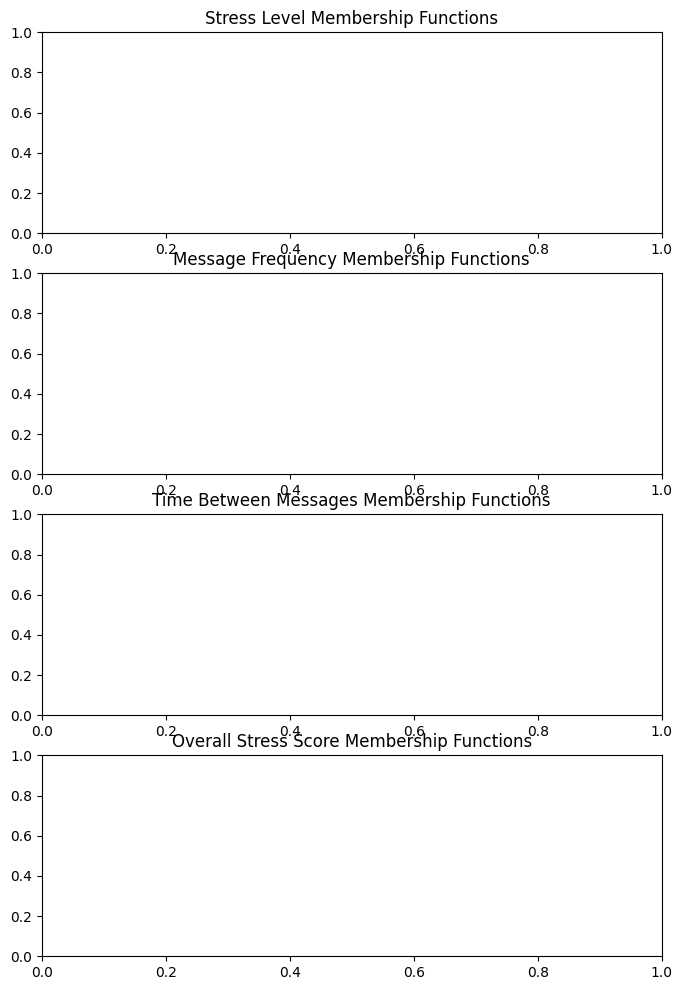

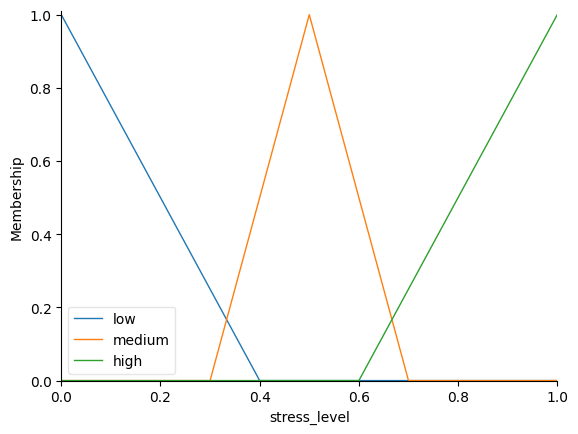

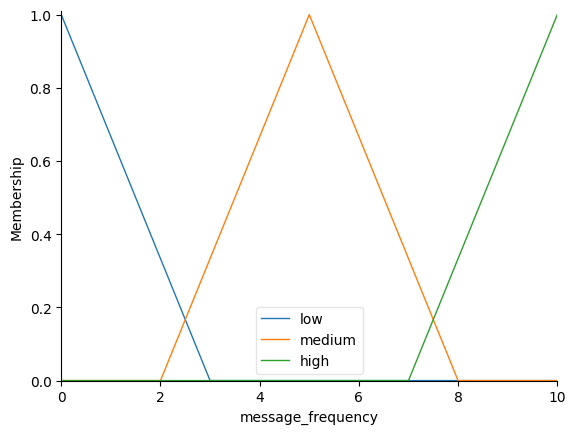

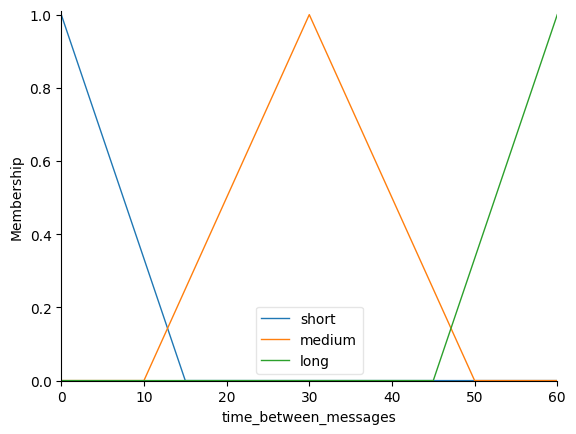

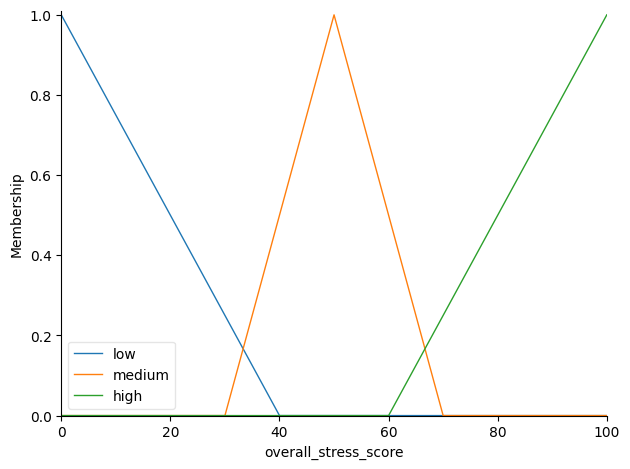

In [ ]:
# Visualize the fuzzy membership functions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))

stress_level.view(ax=ax1)
ax1.set_title('Stress Level Membership Functions')

message_frequency.view(ax=ax2)
ax2.set_title('Message Frequency Membership Functions')

time_between_messages.view(ax=ax3)
ax3.set_title('Time Between Messages Membership Functions')

overall_stress_score.view(ax=ax4)
ax4.set_title('Overall Stress Score Membership Functions')

plt.tight_layout()
plt.show()

In [ ]:
# Test the model with some real examples from the dataset
print("Testing with real examples from the dataset:")
print("=" * 50)

# Get some examples from the test set
test_examples = X_test.sample(5, random_state=42)
for i, text in enumerate(test_examples):
    # Get the true label
    true_label = y_test.loc[text.index]

    # Preprocess and predict
    processed_text = preprocess_text(text)
    features = tfidf_vectorizer.transform([processed_text])
    prediction = rf_classifier.predict(features)[0]
    probability = rf_classifier.predict_proba(features)[0][1]

    print(f"Example {i+1}:")
    print(f"Text: {text[:100]}...")
    print(f"True label: {'Stressed' if true_label == 1 else 'Not Stressed'}")
    print(f"Predicted: {'Stressed' if prediction == 1 else 'Not Stressed'}")
    print(f"Stress probability: {probability:.3f}")
    print("-" * 50)

Testing with real examples from the dataset:


TypeError: must be str, not Series